## Goal is to predict or classify Life Expectancy
- We want to first determine which variables are useful

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import ccf
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import random
import os

from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.tree import plot_tree
from scipy.stats import randint
import pydot

pd.set_option('display.float_format', lambda x: '%.4f' % x)
path = "/Users/rishabtirupathi/Desktop/UIUC/Spring 2024/STAT 432/Final Project"
data_raw = pd.read_csv(f"{path}/Life Expectancy Data.csv")
country_list = sorted(list(set((data_raw['Country']))))
data_raw.columns = [i.strip() for i in data_raw.columns]

colours = random.sample(list(mcolors.XKCD_COLORS.keys()), len(country_list))

data_raw.head()

/var/folders/68/886mn3q57q9f6lcdshz9b8j80000gn/T/ipykernel_74547/1173353754.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0000,263.0000,62,0.0100,71.2796,65.0000,1154,...,6.0000,8.1600,65.0000,0.1000,584.2592,33736494.0000,17.2000,17.3000,0.4790,10.1000
1,Afghanistan,2014,Developing,59.9000,271.0000,64,0.0100,73.5236,62.0000,492,...,58.0000,8.1800,62.0000,0.1000,612.6965,327582.0000,17.5000,17.5000,0.4760,10.0000
2,Afghanistan,2013,Developing,59.9000,268.0000,66,0.0100,73.2192,64.0000,430,...,62.0000,8.1300,64.0000,0.1000,631.7450,31731688.0000,17.7000,17.7000,0.4700,9.9000
3,Afghanistan,2012,Developing,59.5000,272.0000,69,0.0100,78.1842,67.0000,2787,...,67.0000,8.5200,67.0000,0.1000,669.9590,3696958.0000,17.9000,18.0000,0.4630,9.8000
4,Afghanistan,2011,Developing,59.2000,275.0000,71,0.0100,7.0971,68.0000,3013,...,68.0000,7.8700,68.0000,0.1000,63.5372,2978599.0000,18.2000,18.2000,0.4540,9.5000


#### Data preprocessing
- Determine any missing data, linearly interpolate them
- Use correlation analysis to determine which features to use

/var/folders/68/886mn3q57q9f6lcdshz9b8j80000gn/T/ipykernel_74547/2318285226.py:8: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method = 'linear')


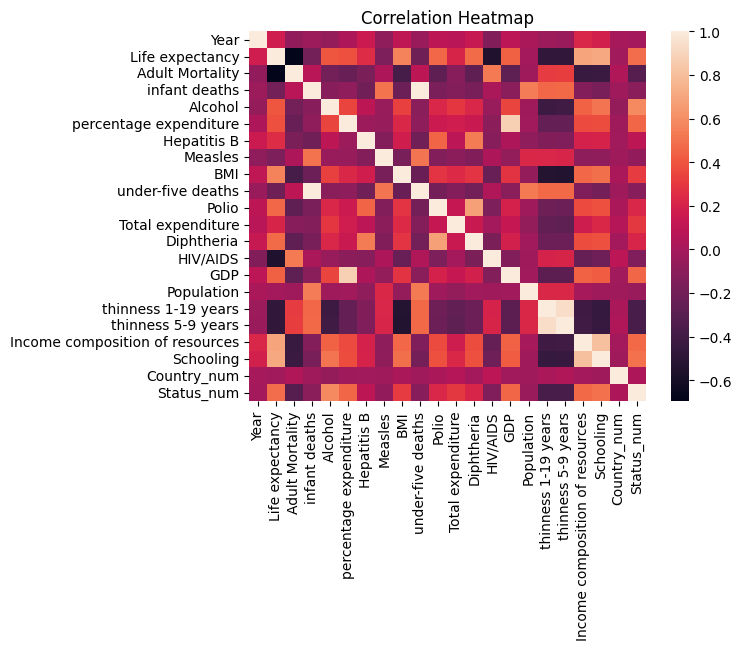

,Column,Correlation
0,Adult Mortality,-0.6957
1,BMI,0.5564
2,HIV/AIDS,-0.5559
3,Income composition of resources,0.6909
4,Schooling,0.7043


In [12]:
df = data_raw.copy()

## Make categorical variables in quantitative
df['Country_num'] = df['Country'].apply(lambda x: country_list.index(x) + 1)
df['Status_num'] = df['Status'].apply(lambda x: 0 if x == 'Developing' else 1)
df['Colour'] = df['Country'].apply(lambda x: colours[country_list.index(x)])

df = df.interpolate(method = 'linear')

# df.to_csv(f"{path}/Interpolated WHO Data.csv")

corr_df = df.drop(columns=['Country', 'Status', 'Colour']).corr()
sns.heatmap(corr_df)
plt.title("Correlation Heatmap")
plt.show()

## Consider the values which have |r| high enough (arbitrary)
life_expectancy_corr = pd.DataFrame({"Column": corr_df.loc["Life expectancy"].index, "Correlation": corr_df.loc["Life expectancy"].values})
life_exp_var = life_expectancy_corr[abs(life_expectancy_corr['Correlation']) >= 0.5]
life_exp_var = life_exp_var[life_exp_var['Column'] != 'Life expectancy'].reset_index(drop = True)
pred = list(life_exp_var['Column'])
life_exp_var

#### Create scatter plot to visualise data

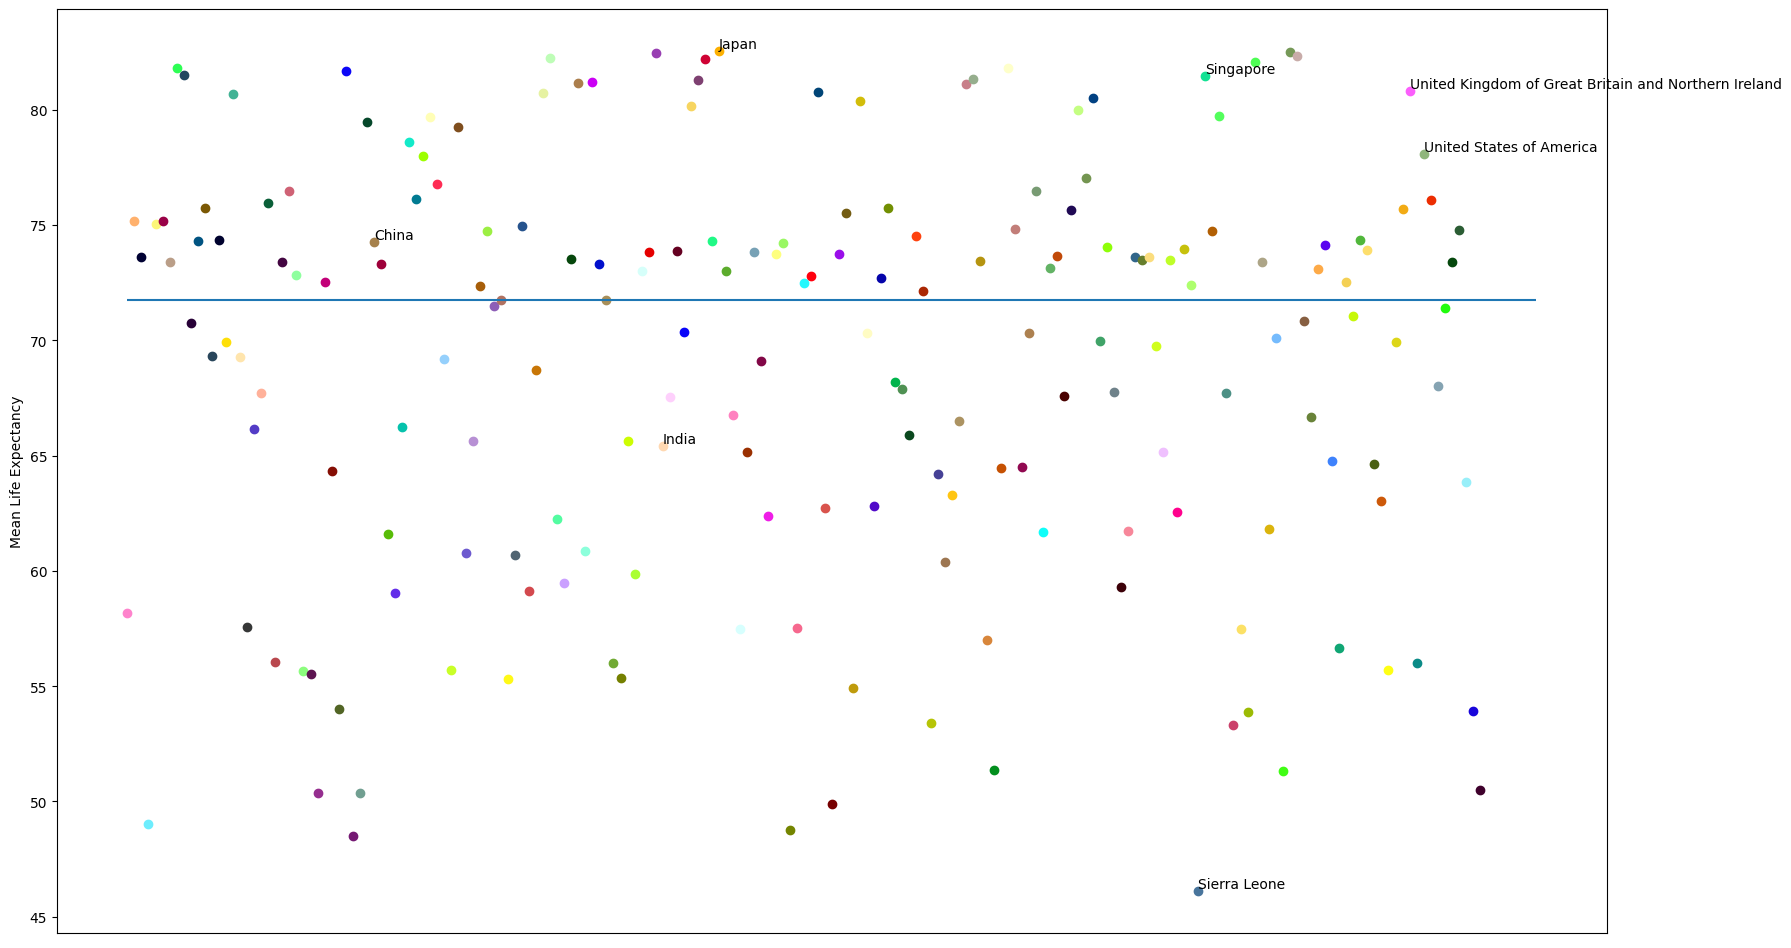

In [3]:
trunc_df = df.copy()
trunc_df['Mean LE'] = trunc_df.groupby(by = 'Country')['Life expectancy'].transform('mean')
trunc_df = trunc_df[['Country', 'Mean LE', 'Colour']].drop_duplicates().reset_index(drop = True)
key_countries = ['United States of America', 'United Kingdom of Great Britain and Northern Ireland', 'Singapore', 'India', 'China']
max_mle = max(trunc_df['Mean LE'])
min_mle = min(trunc_df['Mean LE'])

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 12))
for country, mean_le, colour in zip(trunc_df['Country'], trunc_df['Mean LE'], trunc_df['Colour']):
    axes.scatter(country, mean_le, c = colour, label = country)

    if country in key_countries or mean_le in [max_mle, min_mle]:
        plt.text(country, mean_le, country, va = 'bottom')

axes.set_xticks([])
axes.set_ylabel("Mean Life Expectancy")
axes.hlines(y = trunc_df['Mean LE'].median(), xmin = 0, xmax = 200)
plt.show()

#### Describe life expectancy to determine how to class it

In [4]:
df['Life expectancy'].describe()

count   2938.0000
mean      69.2149
std        9.5108
min       36.3000
25%       63.1000
50%       72.0000
75%       75.6000
max       89.0000
Name: Life expectancy, dtype: float64

#### Logistic Regression
- Because Logistic regression is a classification problem, the output needs to be categorical
- Encode life expectancy as <25% (63.1) as low, 25 - 75 (63.1 - 75.6) as medium, >75% (75.6) as high

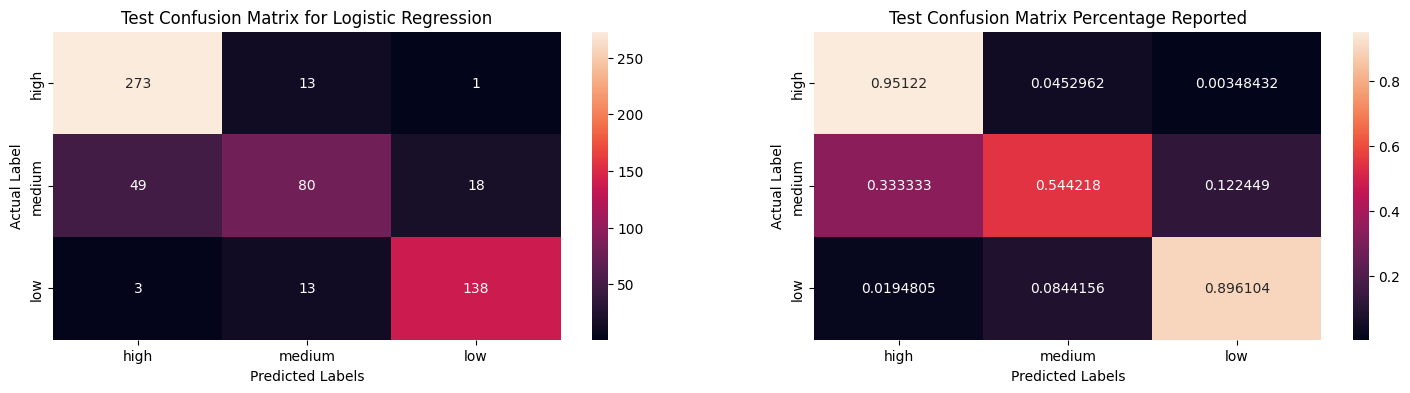

Test Classification Error = 0.165
Train Classification Error = 0.186
              precision    recall  f1-score   support

        high       0.84      0.95      0.89       287
         low       0.88      0.90      0.89       154
      medium       0.75      0.54      0.63       147

    accuracy                           0.84       588
   macro avg       0.82      0.80      0.80       588
weighted avg       0.83      0.84      0.83       588



In [16]:
np.random.seed(12)
model_df = df.copy()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (18, 4))
classes = ['high', 'medium', 'low']

## Bounds for low, medium, high expectancy
q1 = df['Life expectancy'].describe().loc['25%']
q2 = df['Life expectancy'].describe().loc['50%']
q3 = df['Life expectancy'].describe().loc['75%']

model_df['Life expectancy category'] = model_df['Life expectancy'].apply(lambda x: "low" if x < q1 else("medium" if x <= q2 else "high"))

X, y = model_df[pred], model_df['Life expectancy category']

## Split train and test
shuffle_df = model_df.sample(frac=1)
train_idx = int(0.8 * len(shuffle_df))
train_data, test_data = shuffle_df.head(train_idx), shuffle_df.tail(len(shuffle_df) - train_idx)

# train_data.to_csv(f"{path}/Training Data.csv")
# test_data.to_csv(f"{path}/Testing Data.csv")

scaler = StandardScaler()
X_train, y_train = scaler.fit_transform(train_data[pred]), train_data['Life expectancy category']
X_test, y_test = scaler.fit_transform(test_data[pred]), test_data['Life expectancy category']

# Construct model
log_mod = LogisticRegression(random_state = 4)
log_mod.fit(X_train, y_train)
y_pred = log_mod.predict(X_test)
y_train_pred = log_mod.predict(X_train)

## Combine results in df
results = pd.DataFrame({"Country": test_data['Country'], "Year": test_data['Year'], "Prediction": y_pred, "Actual": y_test})

test_conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = ['high', 'medium', 'low'])
sns.heatmap(test_conf_matrix, annot = True, fmt = 'g', ax=axes[0])
axes[0].set_xlabel("Predicted Labels")
axes[0].set_ylabel("Actual Label")
axes[0].set_title("Test Confusion Matrix for Logistic Regression")
axes[0].set_xticks(ticks = [0.5, 1.5, 2.5], labels = classes)
axes[0].set_yticks(ticks = [0.5, 1.5, 2.5], labels = classes)

row_sum = np.sum(test_conf_matrix, axis=1)
percent_confusion = test_conf_matrix/row_sum[:, np.newaxis]
sns.heatmap(percent_confusion, annot = True, fmt = 'g', ax=axes[1])
axes[1].set_xlabel("Predicted Labels")
axes[1].set_ylabel("Actual Label")
axes[1].set_title("Test Confusion Matrix Percentage Reported")
axes[1].set_xticks(ticks = [0.5, 1.5, 2.5], labels = classes)
axes[1].set_yticks(ticks = [0.5, 1.5, 2.5], labels = classes)
plt.show()

test_classification_error = 1-(sum(np.diag(test_conf_matrix))/sum(sum(test_conf_matrix)))

print("Test Classification Error =", round(test_classification_error, 3))
print("Train Classification Error =", round(1-accuracy_score(y_true = y_train, y_pred=y_train_pred), 3))

## Recall = Sensitivity = TP/(TP + FN), Precision = TP/(TP + FP), F1 score = 2 * Precision * Sensitivity/(Precision + Sensitivity), Support = Row Sum
print(classification_report(y_true = y_test, y_pred = y_pred)) 